# Form factor to total density prediction model training
This notebook shows how a deep learning model can be trained to predict total density profiles from form factors. 
It contains the following steps: 
1) Download the data using the NMR lipids API
2) Preprocessing data
3) Training the ML model

### Load the required libraries
Create a virtual environment using e.g. Poetry, and install the following libraries that will be needed. 
The code block below loads the required libraries if they are available in the virtual environment. If errors are generated, check the available libraries e.g. using pip list and install whichever libraries are missing.

In [1]:
import sys
import pandas as pd
import numpy as np

### Initialize a random number generator
This will be used to split the data into training and test sets reproducibly. 

In [2]:
seed = 43715679334954349782040625626900603510
rng = np.random.default_rng(seed)

### Download and initialize the NMR lipids databank
To access the NMR lipids databank, clone the NMRlipids databank git repository into your working folder as explained at https://nmrlipids.github.io/databankLibrary.html: 
```
git clone https://github.com/NMRLipids/Databank.git
```
After doing so, the following code block sets up the databank for use.

In [3]:
# Initialize the NMR lipids databank
databankPath =  './Databank/'   # this is the local path for the cloned Databank git
sys.path.insert(1, databankPath + '/Scripts/BuildDatabank/')
from databankLibrary import *
from new_functions import *
systems = initialize_databank(databankPath)

/home/evenmm/.pyenv/versions/3.12.7/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Databank initialized from the folder: /home/evenmm/NMRlipids/Databank/Data/Simulations


### Gather form factors and total densities in data frames

With the databank initiated, the form factor (ff) and total density (td) data of each simulation can be extracted from the "systems" variable.
Each form factor has a shape of (1000), but the total densities have dimensions that vary. 
Therefore, the total density data are padded with nan in the x and y dimensions to ensure a uniform shape of (200,2). 
After all data is collected, the total densities are split into separate data frames td_x and td_y for each dimension.

In [4]:
all_ff = []
all_td_x = []
all_td_y = []

for system in systems: 
    FFsim, TDsim = get_form_factor_and_total_density(system)

    # Append to the FF list if the data is present
    if isinstance(FFsim, list) and len(FFsim) == 1000:
        all_ff.append(FFsim)

    # Append to the FF list if the data is present
    # The dimensions of TD vary so they must be padded to have uniform length
    max_td_dimension = 200 # maximum allowed length of x and y in total density
    if isinstance(TDsim, list):
        # Calculate the padding needed
        padding_needed = max(0, max_td_dimension - len(TDsim))
        half_padding = padding_needed // 2
        padding_remainder = padding_needed % 2
        # Pad with [0, 0] if the length is less than max_td_dimension
        padding_start = [[np.nan, np.nan]] * half_padding
        padding_end = [[np.nan, np.nan]] * (half_padding + padding_remainder)
        padded_data = padding_start + TDsim + padding_end
        # Truncate if data is longer than max_td_dimension
        padded_data = padded_data[:max_td_dimension]
        # Split into x and y components
        x_data = [pair[0] for pair in padded_data]
        y_data = [pair[1] for pair in padded_data]
        all_td_x.append(x_data)
        all_td_y.append(y_data)

# Convert the data to a pandas DataFrame
sim_FF_df = pd.DataFrame(all_ff)
sim_TD_x_df = pd.DataFrame(all_td_x)
sim_TD_y_df = pd.DataFrame(all_td_y)

# Select only the data, not the indices of all_ff
sim_FF_df = sim_FF_df.map(lambda x: x[1])

print("sim_FF_df.shape", sim_FF_df.shape)
print("sim_TD_x_df.shape", sim_TD_x_df.shape)
print("sim_TD_y_df.shape", sim_TD_y_df.shape)

sim_FF_df.shape (787, 1000)
sim_TD_x_df.shape (787, 200)
sim_TD_y_df.shape (787, 200)


In [5]:
sim_FF_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,11.018759,11.037354,11.093132,11.186069,11.316122,11.483235,11.687335,11.928332,12.206119,12.520574,...,0.453584,0.433207,0.417905,0.408347,0.405022,0.408152,0.417645,0.433118,0.453983,0.479546
1,67.441550,67.409460,67.313202,67.152814,66.928360,66.639932,66.287643,65.871634,65.392073,64.849151,...,0.539054,0.585052,0.631699,0.678851,0.726398,0.774245,0.822318,0.870548,0.918879,0.967259
2,27.198586,27.171876,27.091758,26.958267,26.771463,26.531427,26.238265,25.892106,25.493104,25.041433,...,1.437728,1.428973,1.420036,1.410916,1.401616,1.392136,1.382478,1.372643,1.362632,1.352448
3,78.682713,78.645306,78.533102,78.346150,78.084538,77.748382,77.337835,76.853085,76.294350,75.661884,...,4.687342,4.740075,4.791829,4.842579,4.892303,4.940978,4.988583,5.035098,5.080504,5.124781
4,28.503045,28.479691,28.409638,28.292913,28.129561,27.919647,27.663253,27.360478,27.011441,26.616278,...,2.134429,2.124386,2.113548,2.101926,2.089532,2.076377,2.062474,2.047834,2.032471,2.016395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,100.961527,100.921934,100.803173,100.605294,100.328383,99.972557,99.537970,99.024808,98.433290,97.763671,...,0.773310,0.826190,0.879797,0.933961,0.988542,1.043425,1.098513,1.153723,1.208983,1.264230
783,20.162326,20.135565,20.055297,19.921563,19.734431,19.493998,19.200387,18.853751,18.454271,18.002156,...,1.209838,1.245381,1.280321,1.314643,1.348333,1.381377,1.413763,1.445480,1.476519,1.506869
784,45.915626,45.927144,45.961693,46.019263,46.099834,46.203379,46.329865,46.479249,46.651482,46.846506,...,10.429875,10.518216,10.604726,10.689389,10.772188,10.853107,10.932130,11.009244,11.084433,11.157684
785,24.208609,24.179532,24.092315,23.947003,23.743667,23.482410,23.163361,22.786682,22.352560,21.861213,...,11.258935,11.230925,11.199773,11.165500,11.128131,11.087690,11.044203,10.997699,10.948205,10.895754


Get to know the data at a glance by calling the df name in a code block.

In [6]:
sim_TD_x_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,NaN,NaN,NaN,NaN,-4.173449,-4.129748,-4.086047,-4.042346,-3.998645,-3.954944,...,3.954944,3.998645,4.042346,4.086047,4.129748,4.173449,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.972128,-3.928717,...,3.928717,3.972128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.873326,-3.830995,...,3.830995,3.873326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
783,NaN,NaN,NaN,NaN,-4.184132,-4.140319,-4.096506,-4.052693,-4.008880,-3.965067,...,3.965067,4.008880,4.052693,4.096506,4.140319,4.184132,NaN,NaN,NaN,NaN
784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.726283,-3.685559,...,3.685559,3.726283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785,NaN,NaN,NaN,NaN,-4.618586,-4.570223,-4.521861,-4.473499,-4.425137,-4.376775,...,4.376775,4.425137,4.473499,4.521861,4.570223,4.618586,NaN,NaN,NaN,NaN


In [7]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,NaN,NaN,NaN,NaN,330.175004,330.291425,330.056913,330.380120,330.133787,330.333765,...,330.226517,330.293287,330.364937,330.351165,329.908473,330.201229,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,332.081882,332.381773,...,332.136917,332.236038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333.643040,333.810709,...,333.775786,333.762277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
783,NaN,NaN,NaN,NaN,326.557898,326.161093,325.704671,325.863306,326.119954,325.319172,...,325.732679,325.533976,325.350118,326.501935,326.196577,326.411590,NaN,NaN,NaN,NaN
784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.554804,329.075640,...,328.228938,328.700611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785,NaN,NaN,NaN,NaN,328.402655,326.920857,326.320368,324.537498,324.836051,325.807034,...,327.149339,327.228455,326.035680,325.821772,323.410960,325.887954,NaN,NaN,NaN,NaN


### Plot form factors and total densities

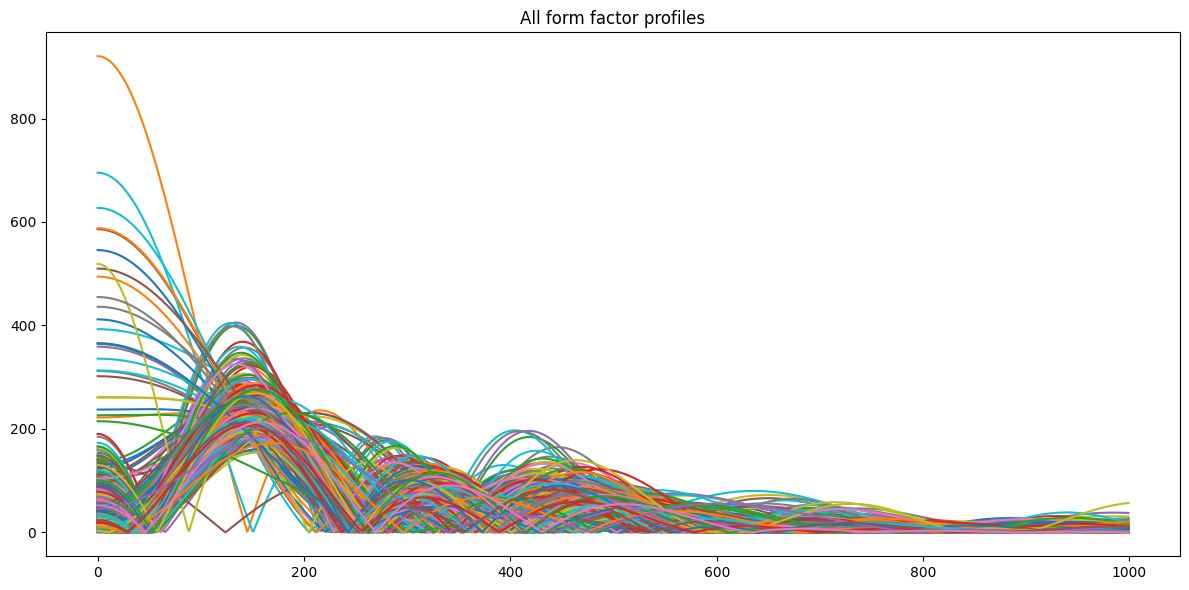

In [8]:
# Plot all form factors
plt.figure(figsize=(12, 6))
for index, row in sim_FF_df.iterrows():
    plt.plot(row.to_list())
plt.title('All form factor profiles')
plt.tight_layout()
plt.show()

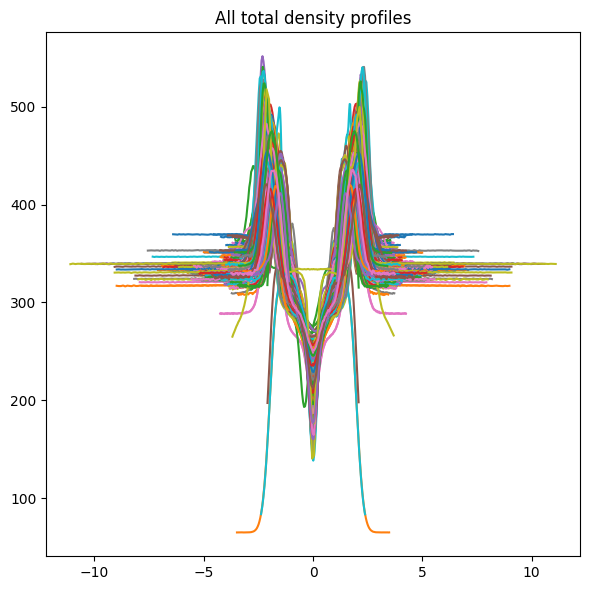

In [9]:
# Plot all total density profiles
plt.figure(figsize=(6, 6))
for index, row in sim_TD_y_df.iterrows():
    plt.plot(sim_TD_x_df.loc[index,:].to_list(), row.to_list())
plt.title('All total density profiles')
plt.tight_layout()
plt.show()

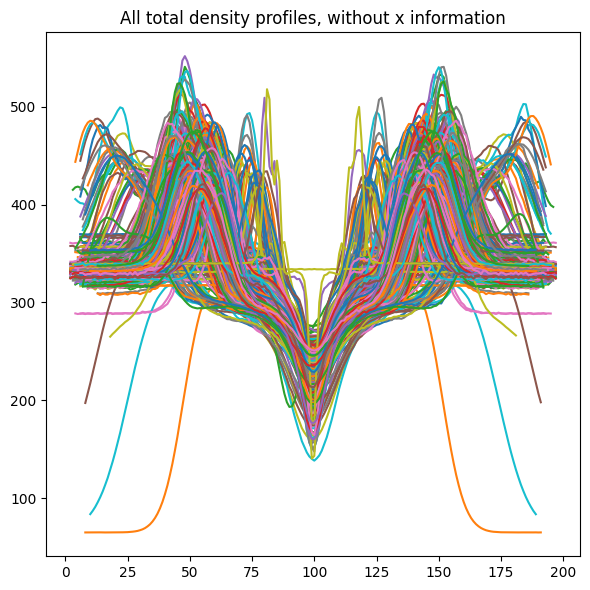

In [10]:
# Plot all total density profiles disregarding the x dimension
plt.figure(figsize=(6, 6))
for index, row in sim_TD_y_df.iterrows():
    plt.plot(row.to_list())
plt.title('All total density profiles, without x information')
plt.tight_layout()
plt.show()
plt.close()

### Rescaling does not accept nan values, we need homogenized y values before this

In [11]:
# Rescale by dividing on largest value
def rescale_df(df):
    min_value = min(df.min())
    max_value = max(df.max())
    return (df-min_value) / max_value

rescaled_sim_FF_df = rescale_df(sim_FF_df)
rescaled_sim_TD_x_df = rescale_df(sim_TD_x_df)
rescaled_sim_TD_y_df = rescale_df(sim_TD_y_df)

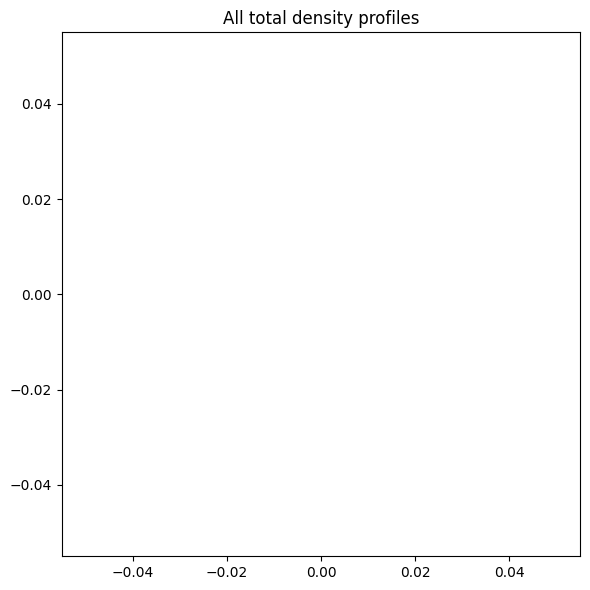

In [12]:
# Plot rescaled total density profiles
plt.figure(figsize=(6, 6))
for index, row in rescaled_sim_TD_y_df.iterrows():
    plt.plot(rescaled_sim_TD_x_df.loc[index,:].to_list(), row.to_list())
plt.title('All total density profiles')
plt.tight_layout()
plt.show()

# A step like Gaussian process regression is needed here to not distort the information by normalizing

### Placeholder: Preprocess data to have the same dimension 
Normalize the values of form factors and total densities

In [13]:
# Standardize each row (each experiment)
def standardize_row(row):
    return (row - row.mean()) / row.std()

scaled_sim_FF_df = sim_FF_df.apply(standardize_row, axis=1)
scaled_sim_TD_x_df = sim_TD_x_df.apply(standardize_row, axis=1)
scaled_sim_TD_y_df = sim_TD_y_df.apply(standardize_row, axis=1)

Concatenate x and y values into a vector to be predicted

In [14]:
sim_TD_df = pd.concat([sim_TD_x_df, sim_TD_y_df], axis=1)
sim_TD_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,NaN,NaN,NaN,NaN,-4.173449,-4.129748,-4.086047,-4.042346,-3.998645,-3.954944,...,330.226517,330.293287,330.364937,330.351165,329.908473,330.201229,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.972128,-3.928717,...,332.136917,332.236038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.873326,-3.830995,...,333.775786,333.762277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
783,NaN,NaN,NaN,NaN,-4.184132,-4.140319,-4.096506,-4.052693,-4.008880,-3.965067,...,325.732679,325.533976,325.350118,326.501935,326.196577,326.411590,NaN,NaN,NaN,NaN
784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.726283,-3.685559,...,328.228938,328.700611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785,NaN,NaN,NaN,NaN,-4.618586,-4.570223,-4.521861,-4.473499,-4.425137,-4.376775,...,327.149339,327.228455,326.035680,325.821772,323.410960,325.887954,NaN,NaN,NaN,NaN


Split into train and test

In [15]:
def split_train_and_test(scaled_sim_FF_df, scaled_sim_TD_x_df, scaled_sim_TD_y_df):
    N_total = sim_FF_df.shape[0]
    N_train = int(round(0.8*N_total,0))
    shuffle_indices = rng.permutation(N_total)
    train_indices = shuffle_indices[0:N_train]
    test_indices = shuffle_indices[N_train:]

    # Select, transpose or not, and convert to numpy float
    train_input = scaled_sim_FF_df.loc[train_indices,:].transpose().astype(np.float32)
    train_output = scaled_sim_TD_y_df.loc[train_indices,:].transpose().values.astype(np.float32)
    test_input = scaled_sim_FF_df.loc[test_indices,:].transpose().astype(np.float32)
    test_output = scaled_sim_TD_y_df.loc[test_indices,:].transpose().values.astype(np.float32)
    
    print("train_input.shape:", train_input.shape)
    print("train_output.shape:", train_output.shape)
    print("test_input.shape:", test_input.shape)
    print("test_output.shape:", test_output.shape)

    return train_input, train_output, test_input, test_output 

train_input, train_output, test_input, test_output = split_train_and_test(scaled_sim_FF_df, scaled_sim_TD_x_df, scaled_sim_TD_y_df)

train_input.shape: (1000, 630)
train_output.shape: (200, 630)
test_input.shape: (1000, 157)
test_output.shape: (200, 157)


Define functions needed for the model training

In [16]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    sorted_loss = np.sort(loss_list)
    loss_quantile_50 = np.percentile(sorted_loss,50)
    loss_quantile_80 = np.percentile(sorted_loss,80)
    loss_quantile_95 = np.percentile(sorted_loss,95)
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for ' + str(amount) + ' cases')
    plt.show()
    
    return [average_loss, mode_loss, median_loss, loss_quantile_50, loss_quantile_80, loss_quantile_95]

def simulation_plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(actual)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = actual[number][0:length]
        y_2 = actual[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = actual[index][0:length].tolist()
        t_y = actual[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[0]][0:length]
    y_1 = prediction[train[0]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[0]][0:length]
    y_2 = actual[train[0]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[0]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[0]],prediction[train[0]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[4]][0:length]
    y_1 = prediction[train[4]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[4]][0:length]
    y_2 = actual[train[4]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[4]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[4]],prediction[train[4]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[9]][0:length]
    y_1 = prediction[train[9]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[9]][0:length]
    y_2 = actual[train[9]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[9]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[9]],prediction[train[9]])))
    
def experiment_predictions(exp_input,prediction):
    random.seed(42)
    train = random.sample(range(0,len(prediction)),10)
    length = int(len(prediction[0])/2)
    for number in train:
        plt.subplot(1,2,1)
        plt.plot(np.arange(0,1,0.001), exp_input[number])
        plt.subplot(1,2,2)
        plt.plot(prediction[number][0:length],prediction[number][length:])
        plt.suptitle('TD prediction for experiment FF index ' + str(number))
        plt.show()
        
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b')
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction on experiment data')
    plt.show()
    
def predicted_plot(prediction):
    prediction = prediction.reshape(400,1)
    length = int(prediction.shape[0]/2)
    plt.plot(prediction[0:length],prediction[length:])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Predicted TotalDensity for the given FormFactor')
    plt.show()

In [18]:
import random
import math
import time
import collections
from collections import Counter
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import statistics as st

from keras.models import Sequential
from keras.layers import Masking, SimpleRNN, Dense

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

#import keras_tuner
#from keras_tuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam

In [21]:
train_input

,150,536,74,754,151,463,75,387,563,131,...,549,698,783,650,282,390,169,228,436,526
0,-0.122261,-0.321251,0.682781,0.428556,-0.568305,0.247942,-0.318513,0.405866,0.654975,0.394555,...,0.449644,4.318267,-0.394161,3.162050,-0.446774,0.873235,-0.501990,1.963685,-0.277596,0.049932
1,-0.122694,-0.321826,0.682018,0.427980,-0.567901,0.247440,-0.319060,0.405224,0.654339,0.394043,...,0.449170,4.317341,-0.394626,3.161896,-0.447234,0.873455,-0.502459,1.963675,-0.278045,0.049459
2,-0.123992,-0.323553,0.679731,0.426249,-0.566689,0.245937,-0.320699,0.403301,0.652430,0.392508,...,0.447747,4.314566,-0.396022,3.161434,-0.448613,0.874113,-0.503867,1.963647,-0.279392,0.048041
3,-0.126156,-0.326431,0.675919,0.423367,-0.564670,0.243431,-0.323430,0.400096,0.649251,0.389950,...,0.445376,4.309941,-0.398349,3.160664,-0.450911,0.875211,-0.506213,1.963601,-0.281637,0.045678
4,-0.129183,-0.330457,0.670587,0.419333,-0.561845,0.239924,-0.327252,0.395612,0.644801,0.386370,...,0.442058,4.303470,-0.401604,3.159586,-0.454126,0.876747,-0.509495,1.963535,-0.284777,0.042371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.762828,-0.683339,-0.882249,-0.662856,-0.710110,-0.778099,-0.673116,-0.670277,-0.633715,-0.774529,...,-0.671401,-0.604221,-0.720850,-0.487020,-0.778590,-0.752743,-0.808697,-0.685299,-0.678227,-0.763081
996,-0.762386,-0.686714,-0.881974,-0.663645,-0.709361,-0.777029,-0.674674,-0.674495,-0.634252,-0.773354,...,-0.671473,-0.604787,-0.720286,-0.484965,-0.777193,-0.752627,-0.806359,-0.685656,-0.678251,-0.762256
997,-0.761924,-0.690095,-0.881387,-0.664476,-0.708634,-0.775968,-0.676250,-0.678716,-0.634772,-0.772191,...,-0.671544,-0.605337,-0.719735,-0.482926,-0.775790,-0.752524,-0.804028,-0.686088,-0.678276,-0.761437
998,-0.761447,-0.693479,-0.880513,-0.665348,-0.707928,-0.774915,-0.677843,-0.682938,-0.635273,-0.771039,...,-0.671613,-0.605868,-0.719195,-0.480907,-0.774385,-0.752434,-0.801706,-0.686594,-0.678302,-0.760624


In [22]:
train_output

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

### Train a neural net

In [20]:
# Starts clock
import time

#from collections import Counter 
#from scipy.signal import savgol_filter

import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense

import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras.optimizers import Adam
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Set TensorFlow verbosity to lowest (only print errors)

from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Masking, SimpleRNN, Dense
#from keras_tuner.tuners import Hyperband

general_start_time = time.time()

# Callbacks are separate functions for chancing behavior of training. 
# In this case we only use EarlyStopping, which stops training, when 
# the validation loss doesn't become smaller after 100 epochs.
# Then the best weights from previous epochs are saved into a model
callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

# This defines an Amsgrad variant of the Adam optimizer. Usually some variant 
# of Adam is first used to give an idea for performance, before other optimizers are used  
Adam = tf.keras.optimizers.Adam(amsgrad=True)

# This defines the given input to be a 1000 long vector
inputs = keras.Input(shape=(1000,))

# This defines a regular neural network layer of 1000 neurons using the activation function called reLu.
# ReLu is also usually used to give an idea for perfomrance, before other activation functions are used
x = layers.Dense(1000, activation='relu')(inputs)

# This defines an output layer, which is a regular neural network layer of 400 neurons using the 
# linear activation function, which means all neurons are activated with their weighted outputs.
outputs = layers.Dense(400, activation='linear')(x)

# This defines a model architecture
model = keras.Model(inputs=inputs, outputs=outputs)

# This compiles a model using a Adam optimizer and the intended training loss, which is mean absolute error
# Usually mean squared error is used for regression predictions, but since the output isn't suitable for it
# due to keras loss functions not knowing the division of x-axis and y-axis values, mean absolute error is used
model.compile(optimizer=Adam, loss='mean_absolute_error')

# This used the given training data to traing the model with 
# max 1500 epochs, validation split of 20 % and a training batch size of 128.
# Usually epoch amounts are around 20 to 100, which is why we are giving the model a lot of tries to adjust
# The given batch size divides the available training data of 490 into 128,128,128 and 106 separate batches 
# that are used to train the network. Larger batch sizes make the network converge faster, while smaller batch sizes 
# make the network updates more granural, increasing the used time 
history = model.fit(train_input, train_output, batch_size=128, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

# Ends clock
general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

# Here we used the defined metrics to evaluate predicted TotalDensities against test TotalDensities
results = metrics(test_output, model.predict(test_input))

# These plot the training history of the model
plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 800
'y' sizes: 200
